In [26]:
!pip install catboost
!pip install --upgrade ipywidgets
!pip install shap
!jupyter nbextension enable --py widgetsnbextension

Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.6/dist-packages (7.5.0)
     |████████████████████████████████| 235kB 2.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.6/dist-packages (7.5.0)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [27]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import catboost
print(catboost.__version__)

0.15.2


In [0]:
from catboost.datasets import amazon
(train_df, test_df) = amazon()

In [29]:
train_df.head()

ACTION  RESOURCE  MGR_ID  ...  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE
0       1     39353   85475  ...            117906       290919     117908
1       1     17183    1540  ...            118536       308574     118539
2       1     36724   14457  ...            267952        19721     117880
3       1     36135    5396  ...            240983       290919     118322
4       1     42680    5905  ...            123932        19793     119325

[5 rows x 10 columns]

In [0]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [31]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Looking on label balance in dataset

In [32]:
print('Labels: {}'.format(set(y)))
print('Zero count - {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count - 1897, One count = 30872


In [33]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations = 500, task_type='GPU')
model.fit(X, y, cat_features=cat_features, verbose=100)

Learning rate set to 0.08341
0:	learn: 0.5756212	total: 111ms	remaining: 55.2s
100:	learn: 0.1463604	total: 8.57s	remaining: 33.9s
200:	learn: 0.1418354	total: 16.6s	remaining: 24.7s
300:	learn: 0.1389159	total: 24.5s	remaining: 16.2s
400:	learn: 0.1368230	total: 32.3s	remaining: 7.97s
499:	learn: 0.1351851	total: 40s	remaining: 0us


In [34]:
model.predict_proba(X)

array([[0.0081, 0.9919],
       [0.0096, 0.9904],
       [0.0208, 0.9792],
       ...,
       [0.0062, 0.9938],
       [0.1524, 0.8476],
       [0.0147, 0.9853]])

In [0]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)

In [0]:
from sklearn.model_selection import train_test_split

data = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_validation,
    label=y_validation,
    cat_features=cat_features
)

In [37]:
model =  CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
#     loss_function='CrossEntropy'
)
model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitterd: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitterd: True
Model params:
{'learning_rate': 0.1, 'iterations': 5, 'loss_function': 'Logloss'}


In [38]:
model =  CatBoostClassifier(
    iterations=15,
#     verbose=5
)
model.fit(train_pool, eval_set=validation_pool)

Learning rate set to 0.5
0:	learn: 0.3971379	test: 0.3960691	best: 0.3960691 (0)	total: 29.9ms	remaining: 419ms
1:	learn: 0.2948071	test: 0.2924021	best: 0.2924021 (1)	total: 63.7ms	remaining: 414ms
2:	learn: 0.2485015	test: 0.2455237	best: 0.2455237 (2)	total: 94.8ms	remaining: 379ms
3:	learn: 0.2234262	test: 0.2192359	best: 0.2192359 (3)	total: 129ms	remaining: 355ms
4:	learn: 0.2003506	test: 0.1938956	best: 0.1938956 (4)	total: 164ms	remaining: 327ms
5:	learn: 0.1916473	test: 0.1831990	best: 0.1831990 (5)	total: 207ms	remaining: 311ms
6:	learn: 0.1842038	test: 0.1759780	best: 0.1759780 (6)	total: 240ms	remaining: 274ms
7:	learn: 0.1808767	test: 0.1722588	best: 0.1722588 (7)	total: 272ms	remaining: 238ms
8:	learn: 0.1783738	test: 0.1678080	best: 0.1678080 (8)	total: 305ms	remaining: 203ms
9:	learn: 0.1769061	test: 0.1658153	best: 0.1658153 (9)	total: 343ms	remaining: 171ms
10:	learn: 0.1761268	test: 0.1653031	best: 0.1653031 (10)	total: 375ms	remaining: 136ms
11:	learn: 0.1752620	tes

In [39]:
model =  CatBoostClassifier(
    iterations=50,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
model1 =  CatBoostClassifier(
    iterations=100,
    learning_rate=0.7,
    train_dir='learning_rate_0.7'
)

model2 =  CatBoostClassifier(
    iterations=100,
    learning_rate=0.01,
    train_dir='learning_rate_0.01'
)

model1.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=20
)

model2.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=20
)

0:	learn: 0.3264513	test: 0.3248170	best: 0.3248170 (0)	total: 39.3ms	remaining: 3.89s
20:	learn: 0.1683868	test: 0.1595638	best: 0.1594426 (19)	total: 608ms	remaining: 2.29s
40:	learn: 0.1623000	test: 0.1604900	best: 0.1592935 (29)	total: 1.18s	remaining: 1.7s
60:	learn: 0.1566107	test: 0.1607838	best: 0.1592935 (29)	total: 1.77s	remaining: 1.13s
80:	learn: 0.1526952	test: 0.1603468	best: 0.1592935 (29)	total: 2.38s	remaining: 557ms
99:	learn: 0.1485242	test: 0.1604420	best: 0.1592935 (29)	total: 2.92s	remaining: 0us

bestTest = 0.1592934723
bestIteration = 29

Shrink model to first 30 iterations.
0:	learn: 0.6853769	test: 0.6853610	best: 0.6853610 (0)	total: 28.6ms	remaining: 2.83s
20:	learn: 0.5575636	test: 0.5568281	best: 0.5568281 (20)	total: 502ms	remaining: 1.89s
40:	learn: 0.4678357	test: 0.4664710	best: 0.4664710 (40)	total: 934ms	remaining: 1.34s
60:	learn: 0.4029487	test: 0.4011429	best: 0.4011429 (60)	total: 1.41s	remaining: 900ms
80:	learn: 0.3552680	test: 0.3531846	best: 

In [41]:
from catboost import MetricVisualizer
MetricVisualizer(['learning_rate_0.7', 'learning_rate_0.01'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
model =  CatBoostClassifier(
    iterations=100,
#     use_best_model=False # no need to cut down trees
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [45]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 98


Cross Validation

In [47]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [48]:
cv_data.head(10)

iterations  test-Logloss-mean  ...  test-AUC-mean  test-AUC-std
0           0           0.296923  ...       0.553022      0.012227
1           1           0.233942  ...       0.564945      0.027618
2           2           0.196598  ...       0.753321      0.043244
3           3           0.184489  ...       0.790716      0.031439
4           4           0.179559  ...       0.803748      0.014034
5           5           0.175799  ...       0.813313      0.006152
6           6           0.174192  ...       0.817983      0.004164
7           7           0.172486  ...       0.822385      0.004958
8           8           0.171843  ...       0.822950      0.004901
9           9           0.170756  ...       0.825785      0.006592

[10 rows x 7 columns]

In [51]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validtion logloss score, not stratified: {:.4f} +- {:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter
))

Best validtion logloss score, not stratified: 0.1651 +- 0.0038 on step 52


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [52]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'learning_rate': 0.5
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [53]:
cv_data.head(10)

iterations  test-Logloss-mean  ...  test-AUC-mean  test-AUC-std
0           0           0.296923  ...       0.553022      0.012227
1           1           0.233942  ...       0.564945      0.027618
2           2           0.196598  ...       0.753321      0.043244
3           3           0.184489  ...       0.790716      0.031439
4           4           0.179559  ...       0.803748      0.014034
5           5           0.175799  ...       0.813313      0.006152
6           6           0.174192  ...       0.817983      0.004164
7           7           0.172486  ...       0.822385      0.004958
8           8           0.171843  ...       0.822950      0.004901
9           9           0.170756  ...       0.825785      0.006592

[10 rows x 7 columns]

Grid searh

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.001, 0.01, 0.5]
}

clf = CatBoostClassifier(
    iterations=20,
    cat_features=cat_features,
    verbose=20
)

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=3
)

results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6923673	total: 18.6ms	remaining: 354ms
19:	learn: 0.6778493	total: 271ms	remaining: 0us
0:	learn: 0.6923682	total: 20.5ms	remaining: 390ms
19:	learn: 0.6778558	total: 264ms	remaining: 0us
0:	learn: 0.6923673	total: 18.6ms	remaining: 354ms
19:	learn: 0.6778559	total: 300ms	remaining: 0us
0:	learn: 0.6853838	total: 16.9ms	remaining: 321ms
19:	learn: 0.5629615	total: 271ms	remaining: 0us
0:	learn: 0.6853928	total: 17.2ms	remaining: 326ms
19:	learn: 0.5630657	total: 249ms	remaining: 0us
0:	learn: 0.6853831	total: 16.5ms	remaining: 313ms
19:	learn: 0.5630284	total: 283ms	remaining: 0us
0:	learn: 0.3972934	total: 17.9ms	remaining: 339ms
19:	learn: 0.1766165	total: 404ms	remaining: 0us
0:	learn: 0.3977266	total: 16.8ms	remaining: 319ms
19:	learn: 0.1764631	total: 409ms	remaining: 0us
0:	learn: 0.3973406	total: 17.3ms	remaining: 329ms
19:	learn: 0.1717642	total: 386ms	remaining: 0us
0:	learn: 0.3971379	total: 29.9ms	remaining: 568ms
19:	learn: 0.1719069	total: 602ms	remaining: 0us


{'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'iterations': 20,
 'learning_rate': 0.5,
 'loss_function': 'Logloss',
 'verbose': 20}

Overfiting detector

In [61]:
model_with_early_stop =  CatBoostClassifier(
    iterations=100,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
print('Tree count: ' + str(model_with_early_stop.tree_count_))

Tree count: 89


In [63]:
model_with_early_stop =  CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [64]:
print('Tree count: ' + str(model_with_early_stop.tree_count_))

Tree count: 42


In [67]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.03,
)

model.fit(
    train_pool,
    verbose=50
)

0:	learn: 0.6562528	total: 65.5ms	remaining: 13s
50:	learn: 0.1942717	total: 2.98s	remaining: 8.7s
100:	learn: 0.1664301	total: 7.15s	remaining: 7.01s
150:	learn: 0.1601569	total: 11.7s	remaining: 3.79s
199:	learn: 0.1569382	total: 16.2s	remaining: 0us


In [68]:
print(model.predict(X_validation)) # don't use predict your your own 

[1. 1. 1. ... 1. 1. 1.]


In [69]:
print(model.predict_proba(X_validation))

[[0.0286 0.9714]
 [0.0162 0.9838]
 [0.0101 0.9899]
 ...
 [0.0318 0.9682]
 [0.0391 0.9609]
 [0.0222 0.9778]]


In [72]:
raw_pred = model.predict(
    X_validation,
    prediction_type = "RawFormulaVal",
)

print(raw_pred)

[3.5242 4.107  4.5861 ... 3.4156 3.2021 3.7871]


In [73]:
from numpy import exp
sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9714 0.9838 0.9899 ... 0.9682 0.9609 0.9778]


In [0]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

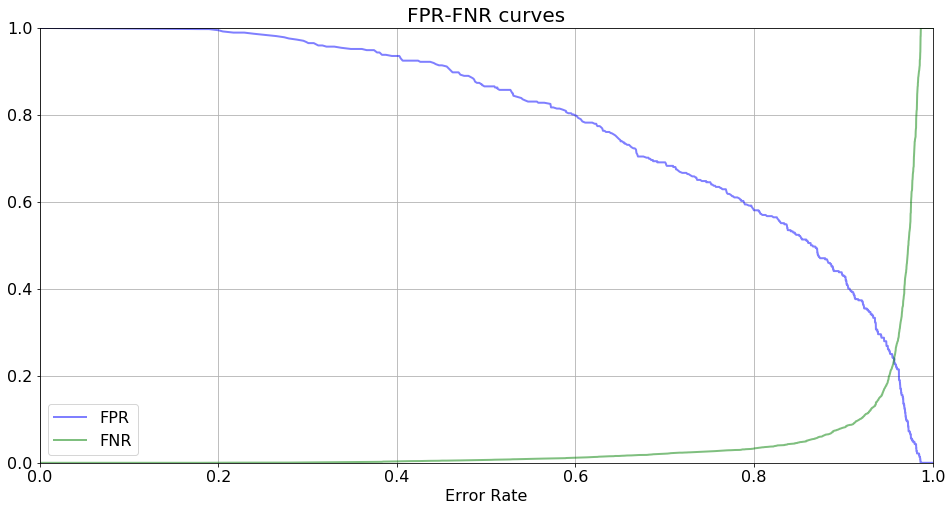

In [108]:
plt.figure(figsize=(16, 8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.xlabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc='lower left', fontsize=16)

Feature Importance

In [76]:
np.array(model.get_feature_importance(prettified=True))

array([['ROLE_DEPTNAME', 18.854592099337363],
       ['RESOURCE', 17.028061417796568],
       ['MGR_ID', 16.07424481782719],
       ['ROLE_CODE', 13.665717803359167],
       ['ROLE_ROLLUP_2', 12.179890737354064],
       ['ROLE_FAMILY_DESC', 9.821699399024284],
       ['ROLE_FAMILY', 5.053895079497491],
       ['ROLE_TITLE', 3.85891134992299],
       ['ROLE_ROLLUP_1', 3.4629872958809274]], dtype=object)

Loss function change

In [78]:
np.array(model.get_feature_importance(
    train_pool,
    'LossFunctionChange',
    prettified=True
))

array([['MGR_ID', 0.02186845947293457],
       ['RESOURCE', 0.019211056850588985],
       ['ROLE_CODE', 0.009805823545108203],
       ['ROLE_FAMILY_DESC', 0.00885578416486808],
       ['ROLE_DEPTNAME', 0.0072976258177284105],
       ['ROLE_ROLLUP_2', 0.00612549628480488],
       ['ROLE_TITLE', 0.0010877873469472162],
       ['ROLE_FAMILY', 0.0003659669175356238],
       ['ROLE_ROLLUP_1', 0.0001002066410684561]], dtype=object)

Shap values

In [79]:
print(model.predict_proba([X.iloc[1, :]]))
print(model.predict_proba([X.iloc[91, :]]))

[[0.0118 0.9882]]
[[0.4754 0.5246]]


In [84]:
shap_values = model.get_feature_importance(
    validation_pool,
    'ShapValues'
)
expected_values = shap_values[0, -1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(6554, 9)


In [87]:
proba = model.predict_proba([X.iloc[1, :]])[0]
raw = model.predict([X.iloc[1,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print(' Raw formula values %.4f' % raw)
print('Probabiliity from raw values %.4f' % sigmoid(raw))

Probabilities [0.0118 0.9882]
 Raw formula values 4.4281
Probabiliity from raw values 0.9882


More psoitive

In [90]:
import shap
shap.initjs()
shap.force_plot(expected_values, shap_values[1, :], X_validation.iloc[1, :])

More negative

In [91]:
import shap
shap.initjs()
shap.force_plot(expected_values, shap_values[91, :], X_validation.iloc[91, :])

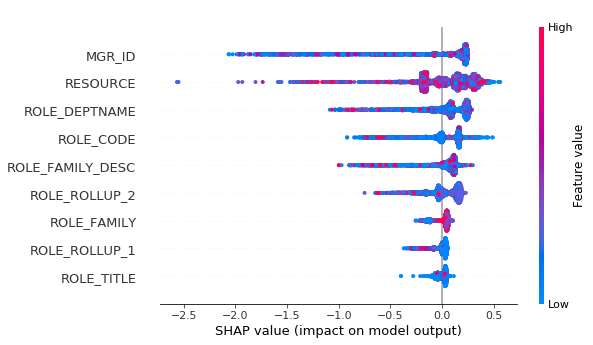

In [92]:
shap.summary_plot(shap_values, X_validation)

In [96]:
# !rm 'catboost_info/snapshot.bkp'

model = CatBoostClassifier(
    iterations=200,
    save_snapshot=True,
    snapshot_file='sanpshot.bkp',
    snapshot_interval=1
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=10
)

Learning rate set to 0.218957
0:	learn: 0.4650683	test: 0.4637697	best: 0.4637697 (0)	total: 67.6ms	remaining: 13.4s
10:	learn: 0.1704213	test: 0.1547593	best: 0.1547593 (10)	total: 778ms	remaining: 13.4s
20:	learn: 0.1608402	test: 0.1417801	best: 0.1417801 (20)	total: 1.59s	remaining: 13.5s
30:	learn: 0.1575992	test: 0.1398024	best: 0.1398024 (30)	total: 2.49s	remaining: 13.6s
40:	learn: 0.1540665	test: 0.1379779	best: 0.1379713 (39)	total: 3.43s	remaining: 13.3s
50:	learn: 0.1513885	test: 0.1371970	best: 0.1371970 (50)	total: 4.32s	remaining: 12.6s
60:	learn: 0.1491857	test: 0.1360957	best: 0.1360957 (60)	total: 5.2s	remaining: 11.9s
70:	learn: 0.1473604	test: 0.1352868	best: 0.1352868 (70)	total: 6.09s	remaining: 11.1s
80:	learn: 0.1454535	test: 0.1344650	best: 0.1344650 (80)	total: 7.04s	remaining: 10.3s
90:	learn: 0.1427703	test: 0.1344421	best: 0.1343647 (85)	total: 7.95s	remaining: 9.52s
100:	learn: 0.1407630	test: 0.1345225	best: 0.1343050 (91)	total: 8.88s	remaining: 8.71s
110

Save model

In [0]:
model = CatBoostClassifier(
    iterations=10,
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False
)

model.save_model('caboost_model.bin')
model.save_model('caboost_model.json', format='json')

In [101]:
model.load_model('caboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'iterations': 10, 'loss_function': 'Logloss', 'logging_level': 'Silent', 'verbose': 0}
0.5


Hyperparams tunning

In [102]:
tunned_model =  CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1    
)


tunned_model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))